In [ ]:
%reset -f


In [ ]:
rm -rf train_data/__MACOSX


Using TensorFlow version: 2.14.0
✅ Dataset extracted to: train_data
Found 750 files belonging to 3 classes.
Epoch 1/10
24/24 [==============================] - 47s 2s/step - loss: 2.0977 - accuracy: 0.4040
Epoch 2/10
24/24 [==============================] - 35s 1s/step - loss: 0.7404 - accuracy: 0.6973
Epoch 3/10
24/24 [==============================] - 36s 2s/step - loss: 0.3906 - accuracy: 0.8560
Epoch 4/10
24/24 [==============================] - 36s 1s/step - loss: 0.1841 - accuracy: 0.9360
Epoch 5/10
24/24 [==============================] - 41s 2s/step - loss: 0.1117 - accuracy: 0.9573
Epoch 6/10
24/24 [==============================] - 36s 1s/step - loss: 0.0781 - accuracy: 0.9760
Epoch 7/10
24/24 [==============================] - 36s 1s/step - loss: 0.0597 - accuracy: 0.9827
Epoch 8/10
24/24 [==============================] - 36s 1s/step - loss: 0.0351 - accuracy: 0.9893
Epoch 9/10
24/24 [==============================] - 36s 1s/step - loss: 0.0488 - accuracy: 0.9840
Epoch 10/1

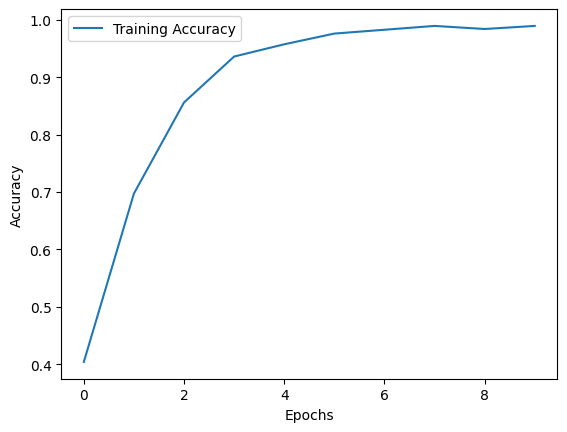

✅ Model saved successfully!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import zipfile
import os

# ✅ Ensure TensorFlow 2.14 is installed
print(f"Using TensorFlow version: {tf.__version__}")

# ✅ Step 1: Define paths
zip_path = "/content/train.zip"  # Ensure this is the correct uploaded file
extract_path = "train_data"  # The directory where extracted images will be saved

# ✅ Step 2: Extract the zip file
if not os.path.exists(extract_path):  # Avoid re-extracting if already done
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(f"✅ Dataset extracted to: {extract_path}")

# ✅ Step 3: Load image dataset from extracted folder
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

train_dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/train_data/train",  # ✅ Load images from the extracted folder
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# ✅ Store class names before applying .map() (Fixes the AttributeError)
class_names = train_dataset.class_names  # Store class names first
num_classes = len(class_names)

# ✅ Normalize images (rescale pixel values)
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

# ✅ Define a CNN Model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")  # ✅ Use stored class count
])

# ✅ Compile Model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ✅ Train Model for 10 Epochs
history = model.fit(train_dataset, epochs=10)

# ✅ Plot Training Results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# ✅ Save Model
model.save("trained_image_model.h5")
print("✅ Model saved successfully!")


In [ ]:
import tensorflow as tf

# ✅ Load the existing H5 model
h5_model_path = "/content/trained_image_model.h5"  # Change to your file
model = tf.keras.models.load_model(h5_model_path, compile=False)

# ✅ Re-save in a new format (fixes batch_shape issue)
new_h5_path = "/content/converted_model.h5"
model.save(new_h5_path, save_format='h5')

print(f"✅ Model successfully re-saved as: {new_h5_path}")


✅ Model successfully re-saved as: /content/converted_model.h5


In [ ]:
import tensorflow as tf
import numpy as np

# ✅ Load the fixed H5 model
fixed_h5_path = "/content/trained_image_model.h5"  # Use the fixed H5 model
model = tf.keras.models.load_model(fixed_h5_path)

# ✅ Define Representative Dataset Function (for INT8 quantization)
def representative_dataset():
    for _ in range(100):  # Use 100 sample images for calibration
        data = np.random.rand(1, 64, 64, 3).astype(np.float32)  # Match input shape
        yield [data]

# ✅ Convert Model to TFLite Format with Full INT8 Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable quantization
converter.representative_dataset = representative_dataset  # Required for INT8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # INT8 ops

# ✅ Ensure Full INT8 Support (Fixes your issue)
converter.inference_input_type = tf.int8  # Ensure input is INT8
converter.inference_output_type = tf.int8  # Ensure output is INT8

# Convert the model
tflite_model = converter.convert()

# ✅ Save the INT8 TFLite Model
tflite_model_path = "/content/trained_image_model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ Model successfully converted to INT8 TFLite format: {tflite_model_path}")


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Model successfully converted to INT8 TFLite format: /content/trained_image_model.tflite


In [ ]:
!rm -rf TinyMaix  # Remove any existing TinyMaix folder
!git clone https://github.com/sipeed/TinyMaix.git


Cloning into 'TinyMaix'...
remote: Enumerating objects: 1749, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 1749 (delta 354), reused 356 (delta 338), pack-reused 1270 (from 2)
Receiving objects: 100% (1749/1749), 48.03 MiB | 17.67 MiB/s, done.
Resolving deltas: 100% (933/933), done.


In [ ]:
!python TinyMaix/tools/tflite2tmdl.py /content/trained_image_model.tflite /content/trained_image_model.tmdl int8 0 "64,64,3" "1,3"


2025-02-27 14:55:06.121522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 14:55:06.121577: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 14:55:06.121610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 14:55:07.038088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
CONV_2D
{'dilation_h_factor': 1, 'dilation_w_factor': 1, 'fused_activation_function': 1, 'padding': 1, 'stride_h': 1, 'stride_w': 1}
    input: serving_default_conv2d_21_input:0
    

In [ ]:
!python TinyMaix/tools/tflite2tmdl.py /content/trained_image_model.tflite /content/trained_image_model.tmdl int8 0 "64,64,3" "1,3"


2025-02-27 15:02:48.328480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 15:02:48.328538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 15:02:48.328571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 15:02:49.263703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
CONV_2D
{'dilation_h_factor': 1, 'dilation_w_factor': 1, 'fused_activation_function': 1, 'padding': 1, 'stride_h': 1, 'stride_w': 1}
    input: serving_default_conv2d_21_input:0
    